# GAN (MNIST) — Jupyter-ready, block-by-block explanation

This notebook explains each section step-by-step with detailed notes on **why** and **how** each part works. Run each cell in order.

In [1]:
%pip install torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Fix for OpenMP library conflict on some systems
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torchvision import datasets, transforms  # Dataset and preprocessing utilities
from torch.utils.data import DataLoader  # For batching data
from torchvision.utils import save_image  # Save generated images
import matplotlib.pyplot as plt  # Visualization

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create directory to save generated images during training
os.makedirs('generated_images', exist_ok=True)

Using device: cpu


## 1. Import Libraries and Setup

**What is this?**
This section imports all necessary libraries for building and training our GAN.

**Why do we need these?**
- `torch` & `torch.nn`: Core PyTorch library for building neural networks
- `torch.optim`: Optimization algorithms (Adam optimizer)
- `torchvision`: Provides MNIST dataset and image utilities
- `matplotlib`: For visualizing images
- `os`: For file and directory operations

**Device Selection:** We check if CUDA (GPU) is available. Training on GPU is much faster than CPU for deep learning tasks.

In [3]:
# Hyperparameters for the GAN architecture and training
latent_dim = 100  # Dimension of random noise vector input to generator
img_size = 28  # Height and width of MNIST images
channels = 1  # Number of color channels (1 for grayscale, 3 for RGB)
batch_size = 128  # Number of images to process in parallel
epochs = 50  # Number of complete passes through the dataset
lr = 0.0002  # Learning rate for both networks (standard for GANs)
beta1, beta2 = 0.5, 0.999  # Adam optimizer parameters (beta1 lower than default 0.9 for GANs)

print(f'latent_dim={latent_dim}, img_size={img_size}, device={device}')

latent_dim=100, img_size=28, device=cpu


## 2. Hyperparameters Configuration

**What are hyperparameters?**
These are the settings that control how our GAN trains. They're not learned during training but set beforehand.

**Key Parameters Explained:**
- **latent_dim (100)**: Size of the random noise vector fed to the generator. Think of it as the "seed" that the generator uses to create images
- **img_size (28)**: MNIST images are 28×28 pixels
- **channels (1)**: Grayscale images have 1 channel (RGB would have 3)
- **batch_size (128)**: Number of images processed together in one training step. Larger batches = more stable training but require more memory
- **epochs (50)**: Number of times we'll iterate through the entire dataset
- **lr (0.0002)**: Learning rate - controls how big the weight updates are. Too high = unstable, too low = slow training
- **beta1, beta2 (0.5, 0.999)**: Parameters for Adam optimizer that control momentum and adaptive learning rates

batch size torch.Size([128, 1, 28, 28])


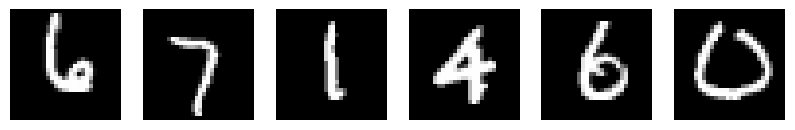

In [4]:
# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor (0-1 range)
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1] range: (x - 0.5) / 0.5
])

# Download and load the MNIST training dataset
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Create DataLoader to batch and shuffle the data
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Get one batch to inspect
imgs, labels = next(iter(dataloader))
print('batch size', imgs.shape)  # Should be [128, 1, 28, 28]

# Denormalize function to convert [-1, 1] back to [0, 1] for visualization
def denorm(x): return (x + 1) / 2

# Display 6 sample images from the dataset
fig, axs = plt.subplots(1, 6, figsize=(10, 2))
for i in range(6):
    axs[i].imshow(denorm(imgs[i]).squeeze(), cmap='gray')  # Remove channel dimension for imshow
    axs[i].axis('off')
plt.show()

## 3. Load and Prepare MNIST Dataset

**What is MNIST?**
MNIST is a dataset of 70,000 handwritten digits (0-9), each 28×28 pixels. It's a classic dataset for learning machine learning.

**Data Preprocessing:**
- **ToTensor()**: Converts PIL images to PyTorch tensors (multi-dimensional arrays)
- **Normalize([0.5], [0.5])**: Scales pixel values from [0, 1] to [-1, 1]. This matches the output range of our Generator's Tanh activation

**DataLoader:**
Creates batches of images and shuffles them for better training. Shuffling prevents the model from learning based on the order of data.

**Visualization:**
We display 6 sample images to verify the data loaded correctly.

In [ ]:
class Generator(nn.Module):
    """
    Generator network that creates fake images from random noise.
    Takes a latent vector (random noise) and progressively transforms it into an image.
    """
    def __init__(self, latent_dim=100, img_size=28, channels=1):
        super().__init__()
        self.img_size = img_size
        self.channels = channels
        
        # Sequential stack of layers that transform noise into image
        self.model = nn.Sequential(
            # Layer 1: Expand from latent_dim to 256
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU allows small negative values (better gradients)
            
            # Layer 2: Expand from 256 to 512
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3: Expand from 512 to 1024
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Output layer: Transform to image size (784 = 28×28×1)
            nn.Linear(1024, img_size * img_size * channels),
            nn.Tanh()  # Tanh outputs values in [-1, 1] to match normalized data
        )

    def forward(self, z):
        """
        Forward pass: Convert noise vector to image
        Args:
            z: Random noise tensor of shape [batch_size, latent_dim]
        Returns:
            Generated image tensor of shape [batch_size, channels, img_size, img_size]
        """
        img = self.model(z)  # Pass through network
        # Reshape flat output to image format: [batch, 1, 28, 28]
        return img.view(z.size(0), self.channels, self.img_size, self.img_size)


# Create generator instance and move to device (GPU/CPU)
generator = Generator(latent_dim, img_size, channels).to(device)

# Test the generator with random noise
z = torch.randn(8, latent_dim, device=device)  # Create 8 random noise vectors
fake = generator(z)  # Generate 8 fake images
print('fake.shape', fake.shape)  # Should be [8, 1, 28, 28]

## 4. Generator Network

**What is the Generator?**
The Generator is a neural network that creates fake images from random noise. It learns to produce realistic-looking handwritten digits.

**Architecture:**
- **Input**: Random noise vector (latent_dim = 100 dimensions)
- **Hidden Layers**: Three fully connected layers (256 → 512 → 1024 neurons) with LeakyReLU activation
- **Output**: 784 neurons (28×28 pixels) with Tanh activation → reshaped to [batch, 1, 28, 28]

**Why this architecture?**
- **Linear layers**: Transform and expand the noise vector into an image
- **LeakyReLU(0.2)**: Activation function that helps with gradient flow (allows small negative values)
- **Tanh**: Output activation that produces values in [-1, 1] range, matching our normalized data

**How it works:**
Random noise → Gradually expand dimensions → Transform into image structure → Output fake image

In [ ]:
class Discriminator(nn.Module):
    """
    Discriminator network that classifies images as real or fake.
    Binary classifier that outputs a probability between 0 (fake) and 1 (real).
    """
    def __init__(self, img_size=28, channels=1):
        super().__init__()
        
        # Sequential stack of layers for classification
        self.model = nn.Sequential(
            # Input layer: Flatten image (784) to 512 features
            nn.Linear(img_size * img_size * channels, 512),
            nn.LeakyReLU(0.2, inplace=True),  # Non-linear activation
            
            # Hidden layer: 512 to 256 features
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Output layer: 256 to 1 (probability)
            nn.Linear(256, 1),
            nn.Sigmoid()  # Sigmoid outputs probability in [0, 1]
        )

    def forward(self, img):
        """
        Forward pass: Classify image as real or fake
        Args:
            img: Image tensor of shape [batch_size, channels, img_size, img_size]
        Returns:
            Probability tensor of shape [batch_size, 1] (0=fake, 1=real)
        """
        img_flat = img.view(img.size(0), -1)  # Flatten image: [batch, 1, 28, 28] → [batch, 784]
        return self.model(img_flat)  # Return probability


# Create discriminator instance and move to device
discriminator = Discriminator(img_size, channels).to(device)
print(discriminator)  # Display architecture

## 5. Discriminator Network

**What is the Discriminator?**
The Discriminator is a binary classifier that determines whether an image is real (from MNIST) or fake (from Generator). It's like an art expert trying to spot forgeries.

**Architecture:**
- **Input**: Flattened image (784 pixels)
- **Hidden Layers**: Two fully connected layers (512 → 256 neurons) with LeakyReLU
- **Output**: Single neuron with Sigmoid activation → probability between 0 and 1

**Why this architecture?**
- **Simpler than Generator**: Classification is easier than generation
- **Sigmoid output**: Produces probability (0 = fake, 1 = real)
- **LeakyReLU**: Helps prevent "dying neurons" problem

**The Adversarial Game:**
- Generator tries to fool the Discriminator (make fake images look real)
- Discriminator tries to correctly identify real vs fake
- This competition drives both networks to improve

In [ ]:
# Loss function: Binary Cross Entropy
# Measures the difference between predicted and actual labels
adversarial_loss = nn.BCELoss()

# Optimizer for Generator: Updates Generator weights to fool Discriminator
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

# Optimizer for Discriminator: Updates Discriminator weights to better classify real/fake
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

def weights_init(m):
    """
    Initialize weights from a normal distribution.
    Called on each layer of the networks.
    
    Args:
        m: A layer module from the neural network
    """
    if isinstance(m, nn.Linear):  # Only initialize Linear layers
        nn.init.normal_(m.weight.data, 0.0, 0.02)  # Mean=0, Std=0.02
        if m.bias is not None: 
            nn.init.constant_(m.bias.data, 0)  # Biases initialized to 0

# Apply weight initialization to both networks
generator.apply(weights_init)
discriminator.apply(weights_init)

## 6. Loss Function, Optimizers, and Weight Initialization

**Loss Function - Binary Cross Entropy (BCE):**
- Measures how well the Discriminator classifies real vs fake images
- Used for both Generator and Discriminator training
- Formula penalizes incorrect predictions

**Optimizers - Adam:**
- Adaptive learning rate optimization algorithm
- Separate optimizer for each network (they have opposite goals!)
- **Beta1 = 0.5**: Lower than default (0.9) for GANs to reduce momentum and prevent oscillation
- **Beta2 = 0.999**: Standard value for adaptive learning rate

**Weight Initialization:**
- Random initialization from normal distribution (mean=0, std=0.02)
- Important for stable training - bad initialization can prevent learning
- Standard practice from DCGAN paper

In [ ]:
def save_sample(generator, epoch, path='generated_images', nrow=5, nz=latent_dim):
    """
    Generate and save a grid of sample images from the Generator.
    This allows us to visually track the Generator's progress during training.
    
    Args:
        generator: The Generator model
        epoch: Current epoch number (used in filename)
        path: Directory to save images
        nrow: Number of images per row in the grid
        nz: Dimension of latent noise vector
    """
    generator.eval()  # Set to evaluation mode (affects dropout, batch norm, etc.)
    os.makedirs(path, exist_ok=True)  # Create directory if it doesn't exist
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        # Generate random noise vectors
        z = torch.randn(nrow * nrow, nz, device=device)
        
        # Generate fake images from noise
        gen_imgs = generator(z).detach().cpu()  # Move to CPU for saving
        
        # Save grid of images to file
        save_image(gen_imgs, f'{path}/epoch_{epoch}.png', nrow=nrow, 
                   normalize=True, range=(-1,1))  # Normalize from [-1,1] to [0,1]
    
    generator.train()  # Set back to training mode
    print(f'Saved: {path}/epoch_{epoch}.png')

# Generate and save initial (untrained) samples to see baseline
save_sample(generator, 0)

## 7. Image Saving Function

**What does this do?**
This function generates and saves sample images during training so we can visualize the Generator's progress.

**Key features:**
- **generator.eval()**: Sets Generator to evaluation mode (disables dropout, etc.)
- **torch.no_grad()**: Disables gradient computation for efficiency (we're not training here)
- **save_image()**: Saves a grid of generated images to a PNG file
- **normalize=True, range=(-1,1)**: Converts from [-1, 1] to [0, 1] for proper display

**Why is this important?**
Visual inspection is crucial for GANs. We can see if the Generator is improving, mode collapsing, or failing to learn.

In [ ]:
def train_one_epoch(generator, discriminator, dataloader, epoch):
    """
    Train both Generator and Discriminator for one complete epoch.
    
    Args:
        generator: Generator network
        discriminator: Discriminator network
        dataloader: DataLoader containing training images
        epoch: Current epoch number
    
    Returns:
        Final discriminator and generator loss values for the epoch
    """
    for i, (imgs, _) in enumerate(dataloader):  # Iterate through batches (ignore labels)
        imgs = imgs.to(device)  # Move images to GPU/CPU
        
        # Create label tensors for real and fake images
        real = torch.ones((imgs.size(0), 1), device=device)   # Label 1 for real images
        fake = torch.zeros((imgs.size(0), 1), device=device)  # Label 0 for fake images

        # ==================== TRAIN GENERATOR ====================
        optimizer_G.zero_grad()  # Reset gradients
        
        # Generate fake images from random noise
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z)
        
        # Calculate Generator loss: how well it fools the Discriminator
        # We want Discriminator to output 1 (real) for generated images
        g_loss = adversarial_loss(discriminator(gen_imgs), real)
        
        g_loss.backward()  # Backpropagate gradients
        optimizer_G.step()  # Update Generator weights

        # ==================== TRAIN DISCRIMINATOR ====================
        optimizer_D.zero_grad()  # Reset gradients
        
        # Loss on real images: should output 1
        real_loss = adversarial_loss(discriminator(imgs), real)
        
        # Loss on fake images: should output 0
        # .detach() prevents gradients from flowing back to Generator
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        
        # Total discriminator loss: average of real and fake losses
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()  # Backpropagate gradients
        optimizer_D.step()  # Update Discriminator weights

        # Print progress every 200 batches
        if i % 200 == 0:
            print(f'Epoch {epoch} [Batch {i}/{len(dataloader)}] '
                  f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')

    # Save sample images at the end of each epoch
    save_sample(generator, epoch)
    return d_loss.item(), g_loss.item()

## 8. Training Function (One Epoch)

**What happens in one training epoch?**
An epoch is one complete pass through the entire dataset. For each batch of real images, we:

**Step 1: Train Generator**
- Create random noise → Generate fake images
- Pass fake images through Discriminator
- **Goal**: Maximize Discriminator's output (make it think fake images are real)
- Calculate loss and update Generator weights

**Step 2: Train Discriminator**
- Pass real images through Discriminator → should output ~1 (real)
- Pass fake images through Discriminator → should output ~0 (fake)
- **Goal**: Correctly classify both real and fake images
- Calculate combined loss and update Discriminator weights

**Key Points:**
- `.detach()`: Detaches fake images from Generator's computation graph when training Discriminator (prevents Generator from being updated)
- Separate optimizers allow independent weight updates
- The adversarial game: Generator wants high Discriminator output, Discriminator wants low output for fakes

In [ ]:
# Main training loop: Train for specified number of epochs
for epoch in range(1, epochs + 1):
    # Train both networks for one complete pass through the dataset
    d_loss_val, g_loss_val = train_one_epoch(generator, discriminator, dataloader, epoch)
    
    # Print epoch summary
    print(f'Finished epoch {epoch}: D_loss={d_loss_val:.4f} G_loss={g_loss_val:.4f}')

# Save the trained model weights to disk
torch.save(generator.state_dict(), 'generator_final.pth')
torch.save(discriminator.state_dict(), 'discriminator_final.pth')
print('Saved model weights: generator_final.pth, discriminator_final.pth')

# To load models later, use:
# generator.load_state_dict(torch.load('generator_final.pth'))
# discriminator.load_state_dict(torch.load('discriminator_final.pth'))

## Summary & Next Steps

**What did we accomplish?**
✅ Built a complete GAN from scratch with Generator and Discriminator networks
✅ Trained on MNIST dataset to generate handwritten digits
✅ Saved generated images to visualize training progress
✅ Saved trained models for future use

**Key Concepts Learned:**
- **Adversarial Training**: Two networks competing against each other
- **Generator**: Creates fake data from random noise
- **Discriminator**: Distinguishes real from fake data
- **The GAN Game**: Generator improves by fooling Discriminator, Discriminator improves by detecting fakes

**What can you do next?**
1. **Examine generated images** in the `generated_images/` folder to see the progression
2. **Experiment with hyperparameters**: Try different learning rates, architectures, or latent dimensions
3. **Generate new images**: Load the saved model and create new digits
4. **Try different datasets**: Apply this same architecture to Fashion-MNIST or other datasets
5. **Explore advanced GANs**: DCGAN (convolutional), StyleGAN, CycleGAN, etc.

**Common Issues & Tips:**
- **Mode collapse**: Generator produces same images → lower learning rate or try different architecture
- **Training instability**: Loss oscillates wildly → adjust learning rates or use gradient penalties
- **Poor quality**: Images stay blurry → train longer or use deeper networks

## 9. Main Training Loop

**What happens here?**
This is where the actual training occurs. We loop through all epochs and train both networks.

**Training Process:**
1. For each epoch (1 to 50):
   - Call `train_one_epoch()` which processes all batches
   - Both Generator and Discriminator are updated multiple times
   - Sample images are saved to track progress
2. After all epochs:
   - Save trained model weights to disk
   - These can be loaded later to generate new images without retraining

**What to expect:**
- **Early epochs**: Generated images look like random noise
- **Middle epochs**: Recognizable digit shapes start to appear
- **Later epochs**: Clear, realistic-looking handwritten digits
- **Loss values**: D_loss should stay around 0.5-0.7 (not too high/low), G_loss may fluctuate

**Time estimate:** On GPU: ~5-10 minutes, On CPU: ~30-60 minutes